# References
* [Bert for text classification](https://www.kaggle.com/code/joydeb28/text-classification-with-bert-pytorch)
* [BBC-News](http://mlg.ucd.ie/datasets/bbc.html)

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import json
import os
from sklearn.metrics import roc_curve
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import transformers
from transformers import BertModel, BertTokenizer
import warnings
warnings.filterwarnings('ignore')
# specify GPU
device = torch.device("cuda")
print(device)



cuda


# 1- Preparing data

## 1.1- Downloading the dataset

In [ ]:
!rm -f bbc-fulltext.zip
!wget http://mlg.ucd.ie/files/datasets/bbc-fulltext.zip
!rm -rf bbc
!unzip -q bbc-fulltext.zip

--2024-03-27 09:32:29--  http://mlg.ucd.ie/files/datasets/bbc-fulltext.zip
Resolving mlg.ucd.ie (mlg.ucd.ie)... 137.43.93.132
Connecting to mlg.ucd.ie (mlg.ucd.ie)|137.43.93.132|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2874079 (2.7M) [application/zip]
Saving to: ‘bbc-fulltext.zip’

bbc-fulltext.zip    100%[===================>]   2.74M  1.20MB/s    in 2.3s    

2024-03-27 09:32:32 (1.20 MB/s) - ‘bbc-fulltext.zip’ saved [2874079/2874079]



## 1.2- Building list of class names

In [ ]:
import os
from sklearn.preprocessing import LabelEncoder

path = "./bbc"
class_names = os.listdir(path)
class_names = [p for p in class_names if os.path.isdir(os.path.join(path, p))]
class_names
lb_encoder = LabelEncoder().fit(class_names)
class_idx = lb_encoder.transform(class_names)


In [ ]:
all_files = []
labels = []
for label in class_names:
  files = os.listdir(os.path.join(path, label))
  files = [os.path.join(path, label, p) for p in files if p.endswith('.txt')]
  all_files = all_files + files
  labels = labels + [label]*len(files)

text = []
for file in all_files:
  with open(file) as f:
    lines = f.readlines()
    f.close()
  text.append(" ".join(lines))

print(len(text))
print(len(labels))

2225
2225


In [ ]:
import pandas as pd

data_table = pd.DataFrame({
    "text": text,
    "labels": labels
})
data_table.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2225 entries, 0 to 2224
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    2225 non-null   object
 1   labels  2225 non-null   object
dtypes: object(2)
memory usage: 34.9+ KB


In [ ]:
data_table.labels.value_counts()

labels
sport            511
business         510
politics         417
tech             401
entertainment    386
Name: count, dtype: int64

<AxesSubplot:xlabel='labels'>

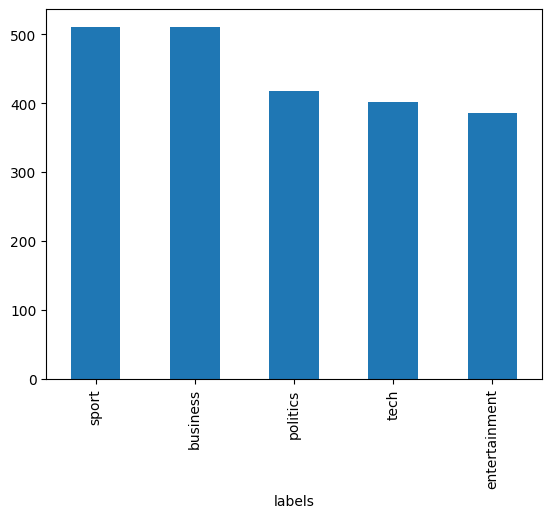

In [ ]:
data_table.labels.value_counts().plot(kind="bar")

In [ ]:
from sklearn.model_selection import train_test_split
train_table, test_table = train_test_split(data_table, test_size=0.2, random_state=2023)
train_table, valid_table = train_test_split(train_table, test_size=0.2, random_state=2023)

In [ ]:
train_table.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1424 entries, 1971 to 16
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    1424 non-null   object
 1   labels  1424 non-null   object
dtypes: object(2)
memory usage: 33.4+ KB


In [ ]:
valid_table.info()

<class 'pandas.core.frame.DataFrame'>
Index: 356 entries, 1084 to 695
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    356 non-null    object
 1   labels  356 non-null    object
dtypes: object(2)
memory usage: 8.3+ KB


In [ ]:
test_table.info()

<class 'pandas.core.frame.DataFrame'>
Index: 445 entries, 294 to 1139
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    445 non-null    object
 1   labels  445 non-null    object
dtypes: object(2)
memory usage: 10.4+ KB


In [ ]:
train_table.iloc[10]["text"]

'Show over for MTV\'s The Osbournes\n \n Rock star Ozzy Osbourne has said his family will not make any more episodes of reality TV show The Osbournes.\n \n "At the end of it I didn\'t like having cameras around the house all the time," the Black Sabbath singer told reporters at the MTV Europe Awards in Rome. His wife Sharon, who also appears in the popular MTV show based on the Osbournes\' family life, agreed. "Now everybody\'s doing reality shows. He\'s done it, he\'s been there, he\'s got to do something else," she said.\n \n Ozzy Osbourne said he had had enough of the work involved in making the series. "When you watch a 25-minute episode, I\'ve been filming all day," he said. Sharon Osbourne is currently appearing as a judge and mentor in ITV1 talent show The X-Factor alongside Simon Cowell and Louis Walsh.\n \n Earlier this year she topped a poll of the most important people in rock, for her part in guiding the career of husband Ozzy and her family. She was the driving force behin

In [ ]:
train_text, valid_text, test_text = [table["text"].tolist() for table in [train_table, valid_table, test_table]]
train_labelidx, valid_labelidx, test_labelidx = [lb_encoder.transform(table["labels"]).tolist() for table in [train_table, valid_table, test_table]]


# Tokenizer

In [ ]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler


class Tokenizer(object):
    def __init__(self, pretrained_name="bert-base-uncased", max_seq_len=512):
        self.pretrained_name = pretrained_name
        self.max_seq_len = max_seq_len
        self.tokenizer = BertTokenizer.from_pretrained(pretrained_name)

    def tokenize(self, text):
        tokens = self.tokenizer.batch_encode_plus(
            text,
            max_length = self.max_seq_len,
            pad_to_max_length=True,
            truncation=True,
            return_token_type_ids=False
        )
        return tokens

tokenizer = Tokenizer()
train_tokens, valid_tokens, test_tokens = [tokenizer.tokenize(text) for text in [train_text, valid_text, test_text]]
train_seq, train_mask, train_y = [torch.tensor(data) for data in [train_tokens['input_ids'], train_tokens['attention_mask'], train_labelidx]]
valid_seq, valid_mask, valid_y = [torch.tensor(data) for data in [valid_tokens['input_ids'], valid_tokens['attention_mask'], valid_labelidx]]
test_seq, test_mask, test_y = [torch.tensor(data) for data in [test_tokens['input_ids'], test_tokens['attention_mask'], test_labelidx]]

train_tensor = TensorDataset(train_seq, train_mask, train_y)
valid_tensor = TensorDataset(valid_seq, valid_mask, valid_y)
test_tensor = TensorDataset(test_seq, test_mask, test_y)

batch_size = 16

train_loader = DataLoader(train_tensor, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_tensor, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_tensor, batch_size=batch_size, shuffle=False)


In [ ]:
for idx, (seq, mask, y) in enumerate(train_loader):
    print(seq.shape, mask.shape, y.shape, y.tolist())
    if idx > 5:
        break


torch.Size([16, 512]) torch.Size([16, 512]) torch.Size([16]) [3, 4, 3, 2, 0, 3, 0, 1, 2, 1, 1, 3, 3, 3, 0, 4]
torch.Size([16, 512]) torch.Size([16, 512]) torch.Size([16]) [0, 4, 1, 2, 3, 3, 3, 4, 0, 2, 3, 4, 0, 4, 3, 3]
torch.Size([16, 512]) torch.Size([16, 512]) torch.Size([16]) [2, 1, 2, 1, 3, 0, 1, 1, 2, 0, 2, 1, 1, 1, 3, 2]
torch.Size([16, 512]) torch.Size([16, 512]) torch.Size([16]) [2, 4, 0, 0, 4, 3, 3, 2, 2, 3, 3, 4, 1, 4, 3, 3]
torch.Size([16, 512]) torch.Size([16, 512]) torch.Size([16]) [3, 1, 2, 2, 1, 4, 4, 1, 2, 1, 3, 3, 0, 0, 4, 3]
torch.Size([16, 512]) torch.Size([16, 512]) torch.Size([16]) [1, 0, 4, 1, 1, 0, 0, 4, 2, 3, 0, 0, 1, 0, 3, 3]
torch.Size([16, 512]) torch.Size([16, 512]) torch.Size([16]) [2, 4, 1, 4, 0, 2, 1, 0, 3, 2, 3, 1, 4, 3, 4, 3]


# 2- Defining Model

In [ ]:
%load_ext autoreload
%autoreload 2


import torch.nn.functional as F
import utils

class NewsClassifier(utils.BaseModel):
    def __init__(self, nclasses, pretrained_name="bert-base-uncased"):
        super().__init__()

        self.nclasses = nclasses
        self.pretrained_name = pretrained_name
        self.feature_extractor = BertModel.from_pretrained(pretrained_name)
        for param in self.feature_extractor.parameters(): # dot not learn
            param.requires_grad = False
        #
        self.dropout = nn.Dropout(0.1)
        self.fc1 = nn.Linear(768,512)
        self.fc2 = nn.Linear(512,self.nclasses)

    def forward(self, token_ids, mask):
        feature = self.feature_extractor(token_ids, attention_mask=mask)
        cls_feature = feature.last_hidden_state[:, 0, :]
        x = self.dropout(F.relu(self.fc1(cls_feature)))
        x = self.fc2(x)
        return x

    @staticmethod
    def from_pretrained(nclasses, path_to_model):
        checkpoint = torch.load(path_to_model)
        if 'loss_meter.weight' in list(checkpoint['model'].keys()):
            del checkpoint['model']['loss_meter.weight']
        pretrained_model = NewsClassifier(nclasses)
        pretrained_model.load_state_dict(checkpoint['model'])
        return pretrained_model

class Predictor(NewsClassifier):
    def __init__(self, idx2name, nclasses=5, pretrained_name="bert-base-uncased"):
        super().__init__(nclasses, pretrained_name)
        self.idx2name = idx2name

    def from_pretrained(self, path_to_model):
        checkpoint = torch.load(path_to_model)
        if 'loss_meter.weight' in list(checkpoint['model'].keys()):
            del checkpoint['model']['loss_meter.weight']
        self.load_state_dict(checkpoint['model'])
        return self

    def predict(self, text):
        """
        text: text | list of texts
        """
        if isinstance(text, str):
            text = [text]
        elif not isinstance(text, list):
            raise Exception(f"type of text = {type(text)}: not supported.")
        else:
            pass
        #
        tokenizer = Tokenizer()
        tokens = tokenizer.tokenize(text)
        seqs, masks = [torch.tensor(data) for data in [tokens['input_ids'], tokens['attention_mask']]]
        preds = super().forward(seqs, masks)
        preds = F.softmax(preds)
        preds = preds.detach().cpu().numpy()
        preds = np.argmax(preds, axis=-1).tolist()
        names = [self.idx2name[idx] for idx in preds]
        return names

####
model = NewsClassifier(len(class_names))
model = model.to(device)

In [ ]:
from transformers import AdamW
from sklearn.utils.class_weight import compute_class_weight

class_wts = compute_class_weight('balanced', classes=np.unique(train_y.numpy()), y=train_y.numpy())
weights= torch.tensor(class_wts,dtype=torch.float)
weights = weights.to(device)

optimizer = AdamW(model.parameters(), lr = 1e-3)
loss_meter = nn.CrossEntropyLoss(weight=weights)

nepoches = 40

model.compile(optimizer, loss_meter,
              metrics=["accuracy", "precision", "recall", "f1_score"],
              save_best_to="the_best.pt",
              save_last_to="last_model.pt")
model.fit(train_loader, valid_loader, nepoches = nepoches)


Epoch:  1/40 | Batch: 89/89:   2%|▎         | 89/3560 [00:12<07:37,  7.58it/s]

                        Loss(per-sample)       accuracy      precision         recall       f1_score
Training summary                  0.0263         0.8617         0.8578         0.8582         0.8575
Validation summary                0.0105         0.9438         0.9417         0.9494         0.9421


Epoch:  2/40 | Batch: 89/89:   5%|▌         | 178/3560 [00:27<07:27,  7.56it/s] 

                        Loss(per-sample)       accuracy      precision         recall       f1_score
Training summary                  0.0076         0.9635         0.9622         0.9629         0.9625
Validation summary                0.0093         0.9579         0.9540         0.9600         0.9557


Epoch:  3/40 | Batch: 89/89:   8%|▊         | 267/3560 [00:42<07:18,  7.51it/s]

                        Loss(per-sample)       accuracy      precision         recall       f1_score
Training summary                  0.0061         0.9656         0.9641         0.9660         0.9650
Validation summary                0.0067         0.9691         0.9663         0.9710         0.9682


Epoch:  4/40 | Batch: 89/89:  10%|█         | 356/3560 [00:56<07:07,  7.49it/s]

                        Loss(per-sample)       accuracy      precision         recall       f1_score
Training summary                  0.0046         0.9747         0.9744         0.9743         0.9744
Validation summary                0.0059         0.9747         0.9720         0.9770         0.9742


Epoch:  5/40 | Batch: 89/89:  12%|█▎        | 445/3560 [01:11<06:56,  7.49it/s]

                        Loss(per-sample)       accuracy      precision         recall       f1_score
Training summary                  0.0036         0.9754         0.9748         0.9764         0.9754
Validation summary                0.0111         0.9551         0.9526         0.9576         0.9535


Epoch:  6/40 | Batch: 89/89:  15%|█▌        | 534/3560 [01:26<06:45,  7.46it/s]

                        Loss(per-sample)       accuracy      precision         recall       f1_score
Training summary                  0.0054         0.9698         0.9689         0.9704         0.9696
Validation summary                0.0088         0.9635         0.9627         0.9639         0.9623


Epoch:  7/40 | Batch: 89/89:  18%|█▊        | 623/3560 [01:40<06:33,  7.46it/s]

                        Loss(per-sample)       accuracy      precision         recall       f1_score
Training summary                  0.0042         0.9754         0.9754         0.9755         0.9754
Validation summary                0.0163         0.9326         0.9465         0.9325         0.9360


Epoch:  8/40 | Batch: 89/89:  20%|██        | 712/3560 [01:56<06:20,  7.48it/s]  

                        Loss(per-sample)       accuracy      precision         recall       f1_score
Training summary                  0.0033         0.9810         0.9805         0.9807         0.9806
Validation summary                0.0067         0.9635         0.9651         0.9649         0.9649


Epoch:  9/40 | Batch: 89/89:  22%|██▎       | 801/3560 [02:11<06:09,  7.47it/s]

                        Loss(per-sample)       accuracy      precision         recall       f1_score
Training summary                  0.0027         0.9853         0.9840         0.9849         0.9844
Validation summary                0.0083         0.9747         0.9722         0.9750         0.9731


Epoch: 10/40 | Batch: 89/89:  25%|██▌       | 890/3560 [02:26<05:59,  7.43it/s]

                        Loss(per-sample)       accuracy      precision         recall       f1_score
Training summary                  0.0039         0.9789         0.9781         0.9792         0.9786
Validation summary                0.0141         0.9522         0.9501         0.9550         0.9511


Epoch: 11/40 | Batch: 89/89:  28%|██▊       | 979/3560 [02:40<05:48,  7.40it/s]

                        Loss(per-sample)       accuracy      precision         recall       f1_score
Training summary                  0.0033         0.9789         0.9786         0.9783         0.9784
Validation summary                0.0120         0.9579         0.9577         0.9599         0.9573


Epoch: 12/40 | Batch: 89/89:  30%|███       | 1068/3560 [02:55<05:36,  7.42it/s]

                        Loss(per-sample)       accuracy      precision         recall       f1_score
Training summary                  0.0022         0.9881         0.9873         0.9881         0.9877
Validation summary                0.0143         0.9494         0.9626         0.9494         0.9534


Epoch: 13/40 | Batch: 89/89:  32%|███▎      | 1157/3560 [03:10<05:23,  7.42it/s]

                        Loss(per-sample)       accuracy      precision         recall       f1_score
Training summary                  0.0016         0.9881         0.9872         0.9883         0.9877
Validation summary                0.0106         0.9691         0.9702         0.9695         0.9693


Epoch: 14/40 | Batch: 89/89:  35%|███▌      | 1246/3560 [03:25<05:12,  7.40it/s]

                        Loss(per-sample)       accuracy      precision         recall       f1_score
Training summary                  0.0025         0.9874         0.9872         0.9877         0.9875
Validation summary                0.0179         0.9410         0.9463         0.9429         0.9415


Epoch: 15/40 | Batch: 89/89:  38%|███▊      | 1335/3560 [03:40<05:01,  7.38it/s]

                        Loss(per-sample)       accuracy      precision         recall       f1_score
Training summary                  0.0019         0.9909         0.9906         0.9906         0.9906
Validation summary                0.0118         0.9607         0.9631         0.9643         0.9626


Epoch: 16/40 | Batch: 89/89:  40%|████      | 1424/3560 [03:55<04:48,  7.40it/s]

                        Loss(per-sample)       accuracy      precision         recall       f1_score
Training summary                  0.0014         0.9930         0.9931         0.9933         0.9932
Validation summary                0.0067         0.9747         0.9766         0.9744         0.9753


Epoch: 17/40 | Batch: 89/89:  42%|████▎     | 1513/3560 [04:10<04:37,  7.37it/s]

                        Loss(per-sample)       accuracy      precision         recall       f1_score
Training summary                  0.0010         0.9958         0.9954         0.9961         0.9957
Validation summary                0.0125         0.9635         0.9665         0.9667         0.9655


Epoch: 18/40 | Batch: 89/89:  45%|████▌     | 1602/3560 [04:25<04:25,  7.37it/s]

                        Loss(per-sample)       accuracy      precision         recall       f1_score
Training summary                  0.0021         0.9881         0.9881         0.9881         0.9881
Validation summary                0.0103         0.9663         0.9684         0.9691         0.9679


Epoch: 19/40 | Batch: 89/89:  48%|████▊     | 1691/3560 [04:40<04:13,  7.37it/s]

                        Loss(per-sample)       accuracy      precision         recall       f1_score
Training summary                  0.0019         0.9895         0.9889         0.9897         0.9893
Validation summary                0.0223         0.9382         0.9521         0.9408         0.9430


Epoch: 20/40 | Batch: 89/89:  50%|█████     | 1780/3560 [04:55<04:01,  7.36it/s]

                        Loss(per-sample)       accuracy      precision         recall       f1_score
Training summary                  0.0012         0.9916         0.9911         0.9910         0.9910
Validation summary                0.0119         0.9775         0.9754         0.9783         0.9766


Epoch: 21/40 | Batch: 89/89:  52%|█████▎    | 1869/3560 [05:10<03:49,  7.36it/s]

                        Loss(per-sample)       accuracy      precision         recall       f1_score
Training summary                  0.0020         0.9888         0.9882         0.9886         0.9884
Validation summary                0.0176         0.9522         0.9517         0.9549         0.9512


Epoch: 22/40 | Batch: 89/89:  55%|█████▌    | 1958/3560 [05:25<03:38,  7.34it/s]

                        Loss(per-sample)       accuracy      precision         recall       f1_score
Training summary                  0.0024         0.9895         0.9887         0.9887         0.9887
Validation summary                0.0074         0.9831         0.9803         0.9843         0.9820


Epoch: 23/40 | Batch: 89/89:  57%|█████▊    | 2047/3560 [05:40<03:26,  7.34it/s]

                        Loss(per-sample)       accuracy      precision         recall       f1_score
Training summary                  0.0014         0.9888         0.9885         0.9887         0.9886
Validation summary                0.0148         0.9691         0.9680         0.9708         0.9688


Epoch: 24/40 | Batch: 89/89:  60%|██████    | 2136/3560 [05:55<03:13,  7.35it/s]

                        Loss(per-sample)       accuracy      precision         recall       f1_score
Training summary                  0.0019         0.9895         0.9887         0.9899         0.9893
Validation summary                0.0128         0.9691         0.9680         0.9699         0.9683


Epoch: 25/40 | Batch: 89/89:  62%|██████▎   | 2225/3560 [06:10<03:02,  7.32it/s]

                        Loss(per-sample)       accuracy      precision         recall       f1_score
Training summary                  0.0015         0.9923         0.9922         0.9922         0.9922
Validation summary                0.0113         0.9635         0.9674         0.9621         0.9640


Epoch: 26/40 | Batch: 89/89:  65%|██████▌   | 2314/3560 [06:25<02:50,  7.32it/s]

                        Loss(per-sample)       accuracy      precision         recall       f1_score
Training summary                  0.0016         0.9916         0.9915         0.9913         0.9914
Validation summary                0.0132         0.9635         0.9624         0.9658         0.9633


Epoch: 27/40 | Batch: 89/89:  68%|██████▊   | 2403/3560 [06:40<02:38,  7.31it/s]

                        Loss(per-sample)       accuracy      precision         recall       f1_score
Training summary                  0.0018         0.9909         0.9904         0.9908         0.9906
Validation summary                0.0089         0.9747         0.9722         0.9741         0.9724


Epoch: 28/40 | Batch: 89/89:  70%|███████   | 2492/3560 [06:55<02:26,  7.29it/s]

                        Loss(per-sample)       accuracy      precision         recall       f1_score
Training summary                  0.0021         0.9902         0.9898         0.9903         0.9901
Validation summary                0.0110         0.9747         0.9724         0.9749         0.9732


Epoch: 29/40 | Batch: 89/89:  72%|███████▎  | 2581/3560 [07:10<02:14,  7.27it/s]

                        Loss(per-sample)       accuracy      precision         recall       f1_score
Training summary                  0.0011         0.9930         0.9927         0.9924         0.9926
Validation summary                0.0109         0.9719         0.9691         0.9725         0.9702


Epoch: 30/40 | Batch: 89/89:  75%|███████▌  | 2670/3560 [07:25<02:02,  7.28it/s]

                        Loss(per-sample)       accuracy      precision         recall       f1_score
Training summary                  0.0018         0.9909         0.9903         0.9909         0.9906
Validation summary                0.0260         0.9382         0.9432         0.9414         0.9389


Epoch: 31/40 | Batch: 89/89:  78%|███████▊  | 2759/3560 [07:40<01:50,  7.28it/s]

                        Loss(per-sample)       accuracy      precision         recall       f1_score
Training summary                  0.0013         0.9930         0.9931         0.9931         0.9931
Validation summary                0.0113         0.9691         0.9682         0.9696         0.9685


Epoch: 32/40 | Batch: 89/89:  80%|████████  | 2848/3560 [07:55<01:37,  7.30it/s]

                        Loss(per-sample)       accuracy      precision         recall       f1_score
Training summary                  0.0018         0.9923         0.9922         0.9923         0.9922
Validation summary                0.0108         0.9719         0.9721         0.9730         0.9722


Epoch: 33/40 | Batch: 89/89:  82%|████████▎ | 2937/3560 [08:10<01:25,  7.27it/s]

                        Loss(per-sample)       accuracy      precision         recall       f1_score
Training summary                  0.0005         0.9972         0.9972         0.9974         0.9973
Validation summary                0.0158         0.9579         0.9593         0.9596         0.9585


Epoch: 34/40 | Batch: 89/89:  85%|████████▌ | 3026/3560 [08:26<01:13,  7.27it/s]

                        Loss(per-sample)       accuracy      precision         recall       f1_score
Training summary                  0.0005         0.9965         0.9965         0.9966         0.9965
Validation summary                0.0107         0.9831         0.9848         0.9842         0.9844


Epoch: 35/40 | Batch: 89/89:  88%|████████▊ | 3115/3560 [08:41<01:01,  7.25it/s]

                        Loss(per-sample)       accuracy      precision         recall       f1_score
Training summary                  0.0027         0.9888         0.9884         0.9891         0.9887
Validation summary                0.0313         0.9326         0.9410         0.9383         0.9353


Epoch: 36/40 | Batch: 89/89:  90%|█████████ | 3204/3560 [08:56<00:48,  7.27it/s]

                        Loss(per-sample)       accuracy      precision         recall       f1_score
Training summary                  0.0012         0.9944         0.9941         0.9943         0.9942
Validation summary                0.0164         0.9635         0.9613         0.9649         0.9618


Epoch: 37/40 | Batch: 89/89:  92%|█████████▎| 3293/3560 [09:11<00:36,  7.28it/s]

                        Loss(per-sample)       accuracy      precision         recall       f1_score
Training summary                  0.0031         0.9853         0.9843         0.9850         0.9846
Validation summary                0.0132         0.9719         0.9710         0.9721         0.9712


Epoch: 38/40 | Batch: 89/89:  95%|█████████▌| 3382/3560 [09:26<00:24,  7.24it/s]

                        Loss(per-sample)       accuracy      precision         recall       f1_score
Training summary                  0.0011         0.9951         0.9950         0.9948         0.9949
Validation summary                0.0130         0.9775         0.9748         0.9783         0.9761


Epoch: 39/40 | Batch: 89/89:  98%|█████████▊| 3471/3560 [09:42<00:12,  7.24it/s]

                        Loss(per-sample)       accuracy      precision         recall       f1_score
Training summary                  0.0004         0.9965         0.9962         0.9966         0.9964
Validation summary                0.0214         0.9438         0.9473         0.9483         0.9454


Epoch: 40/40 | Batch: 89/89: 100%|██████████| 3560/3560 [09:57<00:00,  7.24it/s]

                        Loss(per-sample)       accuracy      precision         recall       f1_score
Training summary                  0.0009         0.9937         0.9936         0.9938         0.9937
Validation summary                0.0074         0.9831         0.9834         0.9830         0.9831


Epoch: 40/40 | Batch: 89/89: 100%|██████████| 3560/3560 [10:00<00:00,  5.93it/s]


In [ ]:
rs =model.evaluate(test_loader)

Evaluation: 
----------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.96      0.98      0.97        92
           1       0.99      0.99      0.99        84
           2       0.99      0.97      0.98        88
           3       1.00      1.00      1.00        94
           4       0.99      0.99      0.99        87

    accuracy                           0.98       445
   macro avg       0.98      0.98      0.98       445
weighted avg       0.98      0.98      0.98       445

Loss(per-sample):         0.0065


In [ ]:
#pretrained_model = NewsClassifier.from_pretrained(5, "last_model.pt")
pretrained_model = NewsClassifier.from_pretrained(5, "the_best.pt")
pretrained_model.compile(optimizer, loss_meter,
              metrics=["accuracy", "precision", "recall", "f1_score"],
              save_best_to="the_best.pt",
              save_last_to="last_model.pt")
pretrained_model.to(device)
rs = pretrained_model.evaluate(test_loader)

Evaluation: 
----------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.84      0.99      0.91        92
           1       0.98      0.99      0.98        84
           2       1.00      0.90      0.95        88
           3       1.00      0.97      0.98        94
           4       0.99      0.93      0.96        87

    accuracy                           0.96       445
   macro avg       0.96      0.95      0.96       445
weighted avg       0.96      0.96      0.96       445

Loss(per-sample):         0.0097


In [ ]:
idx2name = dict(zip(class_idx, class_names))
predictor = Predictor(idx2name)
predictor.from_pretrained("last_model.pt")
preds = predictor.predict(test_text[:4])
print(preds)

['entertainment', 'business', 'entertainment', 'sport']


In [ ]:
text1 = """
For a while, that approach seemed to work. As the boy-wonder of crypto, Bankman-Fried got rich faster than almost anyone in history, amassing an estimated $26bn in personal wealth, countless magazine covers and sweeping political influence. The flameout was even faster.

The tweet was, as discussed, net bad. Billions gushed out of the platform in less than five days. When it was all over, more than $8bn in customer funds were missing and the company was bankrupt. Five weeks after that, prosecutors in Manhattan charged Bankman-Fried, who had already resigned, with several financial offences including wire fraud, securities fraud, commodities fraud and money laundering.

Over four weeks of trial, two contradictory stories emerged. In one, the former mogul was a brilliant but hapless savant, whose mistakes as CEO allowed for massive fraud to be carried out under his nose. In the other, supported by former members of his inner circle, Bankman-Fried syphoned billions of dollars of customer money, banking on the odds he'd never be caught.

Both tellings reveal how tightly the fortunes of FTX were tied to the image of its founder, whose oddball magnetism drew former presidents, celebrities, and corporate titans into his orbit and his multi-billion dollar gamble.
"""
predictor.predict(text1)

['business']

In [ ]:
text1 = """
For a while, that approach seemed to work. As the boy-wonder of crypto, Bankman-Fried got rich faster than almost anyone in history, amassing an estimated $26bn in personal wealth, countless magazine covers and sweeping political influence. The flameout was even faster.

The tweet was, as discussed, net bad. Billions gushed out of the platform in less than five days. When it was all over, more than $8bn in customer funds were missing and the company was bankrupt. Five weeks after that, prosecutors in Manhattan charged Bankman-Fried, who had already resigned, with several financial offences including wire fraud, securities fraud, commodities fraud and money laundering.

Over four weeks of trial, two contradictory stories emerged. In one, the former mogul was a brilliant but hapless savant, whose mistakes as CEO allowed for massive fraud to be carried out under his nose. In the other, supported by former members of his inner circle, Bankman-Fried syphoned billions of dollars of customer money, banking on the odds he'd never be caught.

Both tellings reveal how tightly the fortunes of FTX were tied to the image of its founder, whose oddball magnetism drew former presidents, celebrities, and corporate titans into his orbit and his multi-billion dollar gamble.
"""
predictor.predict(text1)

['business']

[url2text](https://stackoverflow.com/questions/45768441/hangs-on-open-url-with-urllib-python3)

In [ ]:
class_names

['entertainment', 'sport', 'politics', 'business', 'tech']

In [ ]:
from data import link2text
links = {
    "https://www.bbc.com/news/business-67304260": "business",
    "https://www.bbc.com/news/business-67305453": "business",
    "https://www.bbc.com/sport/football/67323707": "sport",
    "https://www.bbc.com/sport/football/67324261": "sport",
    "https://www.bbc.com/news/technology-67302788": "tech",
    "https://www.bbc.com/news/science-environment-67243772": "tech",
    "https://www.bbc.com/news/entertainment-arts-67207695": "entertainment",
    "https://www.bbc.com/news/entertainment-arts-67311637": "entertainment",
    "https://www.bbc.com/news/uk-politics-67320861": "politics",
    "https://www.bbc.com/news/world-europe-67321777": "politics"
}
text, labels = link2text(links)
#
preds = predictor.predict(text)
print("{:>15s} | {:<15s}".format("Label", "Prediction"))
print("-"*100)
for lb, pred in zip(labels, preds):
    print("{:>15s} | {:<15s}".format(lb, pred))
print("="*100)

URLError: <urlopen error [SSL: UNEXPECTED_EOF_WHILE_READING] EOF occurred in violation of protocol (_ssl.c:1007)>